In [9]:
import os
import random
import shutil
import time
from PIL import Image
import concurrent.futures
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np

In [10]:
import os
import random
import shutil
import time
from PIL import Image
import concurrent.futures

# ฟังก์ชันสำหรับปรับขนาดและบันทึกภาพ
def resize_and_save(item, input_path, output_path):
    try:
        img_path = os.path.join(input_path, item)
        if os.path.isfile(img_path):
            with Image.open(img_path) as im:
                imResize = im.resize((224, 224), Image.LANCZOS)  # เปลี่ยนขนาดเป็น (224, 224)
                if imResize.mode != 'RGB':
                    imResize = imResize.convert('RGB')
                save_path = os.path.join(output_path, item)
                imResize.save(save_path, 'JPEG', quality=90)
                print(f"Processed {item} - {imResize.size}")
    except Exception as e:
        print(f"Error processing {item}: {e}")

# กำหนดพาธไปยังโฟลเดอร์
base_path = r'C:\Users\black\OneDrive\Desktop\Dataset'
class_1_dir = os.path.join(base_path, 'WEAPON_KNIFE')
class_0_dir = os.path.join(base_path, 'PASS_NOKNIFE')

# พาธสำหรับ train และ test
train_dir = os.path.join(base_path, 'train')
test_dir = os.path.join(base_path, 'test')

# สร้างโฟลเดอร์ train และ test ถ้ายังไม่มี
for subdir in ['class_1', 'class_0']:
    os.makedirs(os.path.join(train_dir, subdir), exist_ok=True)
    os.makedirs(os.path.join(test_dir, subdir), exist_ok=True)

# ฟังก์ชันสำหรับแบ่ง dataset และปรับขนาดภาพ
def split_and_resize_dataset(source_dir, train_dir, test_dir, split_ratio=0.8):
    files = os.listdir(source_dir)
    random.shuffle(files)
    split_index = int(len(files) * split_ratio)

    train_files = files[:split_index]
    test_files = files[split_index:]

    def process_files(files, dest_dir):
        with concurrent.futures.ThreadPoolExecutor() as executor:
            futures = [executor.submit(resize_and_save, item, source_dir, dest_dir) for item in files]
            for future in concurrent.futures.as_completed(futures):
                future.result()
    
    process_files(train_files, train_dir)
    process_files(test_files, test_dir)
    
    return len(train_files), len(test_files)  # Return the count of files processed

# แบ่ง dataset สำหรับ class 1 และ class 0 และปรับขนาดภาพ
start_time = time.time()
train_1, test_1 = split_and_resize_dataset(class_1_dir, os.path.join(train_dir, 'class_1'), os.path.join(test_dir, 'class_1'))
train_0, test_0 = split_and_resize_dataset(class_0_dir, os.path.join(train_dir, 'class_0'), os.path.join(test_dir, 'class_0'))
end_time = time.time()

print(f"Dataset split and resized in {end_time - start_time:.2f} seconds.")
print(f"Total images in train set: {train_1 + train_0}")
print(f"Total images in test set: {test_1 + test_0}")


Processed 035985.jpg - (224, 224)Processed 024959.jpg - (224, 224)

Processed 030735.jpg - (224, 224)
Processed 032537.jpg - (224, 224)
Processed 034754.jpg - (224, 224)
Processed 041728.jpg - (224, 224)
Processed 023948.jpg - (224, 224)
Processed 023659.jpg - (224, 224)
Processed 009697.jpg - (224, 224)
Processed 037527.jpg - (224, 224)
Processed 038670.jpg - (224, 224)
Processed 028538.jpg - (224, 224)
Processed 035045.jpg - (224, 224)
Processed 019285.jpg - (224, 224)
Processed 022526.jpg - (224, 224)
Processed 030791.jpg - (224, 224)
Processed 010625.jpg - (224, 224)
Processed 029836.jpg - (224, 224)
Processed 031336.jpg - (224, 224)
Processed 032246.jpg - (224, 224)
Processed 029246.jpg - (224, 224)
Processed 030825.jpg - (224, 224)
Processed 033623.jpg - (224, 224)
Processed 040032.jpg - (224, 224)
Processed 029657.jpg - (224, 224)
Processed 028230.jpg - (224, 224)
Processed 032620.jpg - (224, 224)
Processed 041653.jpg - (224, 224)
Processed 037039.jpg - (224, 224)
Processed 0330

In [11]:
# เตรียมข้อมูลและสร้างชุดข้อมูลการฝึกและการทดสอบ
def preprocess_image(filename, label, target_size=(224, 224)):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, target_size)
    image = image / 255.0
    return image, label

def load_dataset(file_list, labels, target_size=(224, 224)):
    dataset = tf.data.Dataset.from_tensor_slices((file_list, labels))
    dataset = dataset.map(lambda x, y: preprocess_image(x, y, target_size))
    return dataset

# สร้าง tf.data.Dataset สำหรับการฝึกและทดสอบ
X_train = [os.path.join(train_dir, 'class_1', fname) for fname in os.listdir(os.path.join(train_dir, 'class_1'))] + \
          [os.path.join(train_dir, 'class_0', fname) for fname in os.listdir(os.path.join(train_dir, 'class_0'))]
y_train = [1] * len(os.listdir(os.path.join(train_dir, 'class_1'))) + [0] * len(os.listdir(os.path.join(train_dir, 'class_0')))

X_test = [os.path.join(test_dir, 'class_1', fname) for fname in os.listdir(os.path.join(test_dir, 'class_1'))] + \
         [os.path.join(test_dir, 'class_0', fname) for fname in os.listdir(os.path.join(test_dir, 'class_0'))]
y_test = [1] * len(os.listdir(os.path.join(test_dir, 'class_1'))) + [0] * len(os.listdir(os.path.join(test_dir, 'class_0')))

train_dataset = load_dataset(X_train, y_train).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = load_dataset(X_test, y_test).batch(32).prefetch(tf.data.AUTOTUNE)


In [12]:
# สร้างโมเดล VGG16
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg_model.trainable = False

input_tensor = Input(shape=(224, 224, 3))
x = vgg_model(input_tensor)
x = Flatten()(x)
output_tensor = Dense(1, activation='sigmoid')(x)

model = Model(inputs=input_tensor, outputs=output_tensor)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [13]:
# ฝึกโมเดล
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(
    train_dataset,
    epochs=6,
    validation_data=test_dataset,
    callbacks=[early_stopping]
)


Epoch 1/6
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 1582s 1s/step - accuracy: 0.9877 - loss: 0.0946 - val_accuracy: 0.8799 - val_loss: 8.5656
Epoch 2/6
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 1591s 1s/step - accuracy: 0.9529 - loss: 2.8620 - val_accuracy: 0.8799 - val_loss: 14.7696
Epoch 3/6
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 1564s 1s/step - accuracy: 0.9391 - loss: 4.6045 - val_accuracy: 0.8800 - val_loss: 9.0311
Epoch 4/6
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 1564s 1s/step - accuracy: 0.9549 - loss: 2.1138 - val_accuracy: 0.9134 - val_loss: 4.9433
Epoch 5/6
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 1566s 1s/step - accuracy: 0.9722 - loss: 0.9876 - val_accuracy: 0.9310 - val_loss: 3.5652
Epoch 6/6
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 1580s 1s/step - accuracy: 0.9805 - loss: 0.5796 - val_accuracy: 0.9345 - val_loss: 3.1821


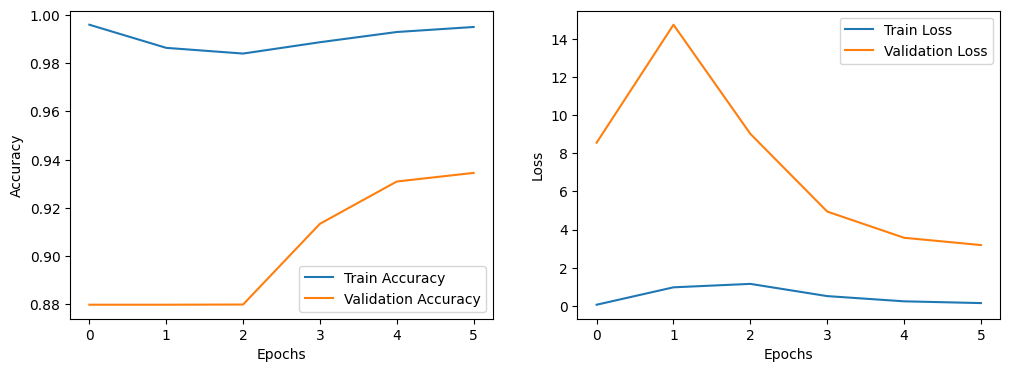

In [14]:
# แสดงกราฟความแม่นยำและการสูญเสีย
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()
